In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd

from astropy import coordinates
from astropy.coordinates import match_coordinates_sky
import astropy.units as u
import astroquery
from astroquery.irsa import Irsa
from astroquery.vizier import Vizier
from astropy.table import Table, join, Column, hstack

from astropy.units import Quantity
from astroquery.gaia import Gaia

Irsa.ROW_LIMIT = -1
Vizier.ROW_LIMIT = -1

from astropy.io import ascii as asci

import matplotlib.pyplot as plt

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


# Get the data

In [2]:
#obj = ["3C 454.3", 343.49062, 16.14821, 1.0]
#obj = ["PKS J0006-0623", 1.55789, -6.39315, 1]
obj = ["M87", 187.705930, 12.391123, 1.0]
#### name, ra, dec, radius of cone (in deg)

obj_name = obj[0]
obj_ra   = obj[1]
obj_dec  = obj[2]
cone_radius  = obj[3]

In [3]:
obj_coord = coordinates.SkyCoord(ra=obj_ra, dec=obj_dec, unit=(u.deg, u.deg), frame="icrs")

# Try GAIA and 2MASS

- in gaiadr1 and gaiadr2 they also provide 2mass, allwise, sdss "best neigbour" pairs 
- catalogs provided by GAIA:
    - gaiadr1.gaiadr1.allwise_original_valid
    - gaiadr1.gaiadr1.gsc23_original_valid
    - gaiadr1.gaiadr1.ppmxl_original_valid
    - gaiadr1.gaiadr1.sdssdr9_original_valid
    - gaiadr1.gaiadr1.tmass_original_valid
    - gaiadr1.gaiadr1.ucac4_original_valid
    - gaiadr1.gaiadr1.urat1_original_valid

In [4]:
cmd = "SELECT * FROM gaiadr2.gaia_source AS g, \
gaiadr2.tmass_best_neighbour AS tbest, \
gaiadr1.tmass_original_valid AS tmass \
WHERE g.source_id = tbest.source_id AND tbest.tmass_oid = tmass.tmass_oid AND CONTAINS(POINT('ICRS',g.ra,g.dec),\
CIRCLE('ICRS'," + str(obj_ra) + "," + str(obj_dec) + "," + str(cone_radius) + "))=1;"

print(cmd)

job1 = Gaia.launch_job_async(cmd, dump_to_file=True)
print (job1)

SELECT * FROM gaiadr2.gaia_source AS g, gaiadr2.tmass_best_neighbour AS tbest, gaiadr1.tmass_original_valid AS tmass WHERE g.source_id = tbest.source_id AND tbest.tmass_oid = tmass.tmass_oid AND CONTAINS(POINT('ICRS',g.ra,g.dec),CIRCLE('ICRS',187.70593,12.391123,1.0))=1;
Jobid: 1543113851085O
Phase: COMPLETED
Owner: None
Output file: async_20181124234411.vot
Results: None


In [5]:
gaia_2mass = job1.get_results()
print(len(gaia_2mass['source_id']))

# print(gaia_2mass['ra', 'dec', 'ra_2', 'dec_2', 'phot_g_mean_mag', 'j_m']) 

3772


# Try GAIA and WISE

In [6]:
cmd = "SELECT * FROM gaiadr2.gaia_source AS g, \
gaiadr2.allwise_best_neighbour AS wbest, \
gaiadr1.allwise_original_valid AS allwise \
WHERE g.source_id = wbest.source_id AND wbest.allwise_oid = allwise.allwise_oid AND CONTAINS(POINT('ICRS',g.ra,g.dec),\
CIRCLE('ICRS'," + str(obj_ra) + "," + str(obj_dec) + "," + str(cone_radius) + "))=1;"

print(cmd)

job2 = Gaia.launch_job_async(cmd, dump_to_file=True)
print(job2)

SELECT * FROM gaiadr2.gaia_source AS g, gaiadr2.allwise_best_neighbour AS wbest, gaiadr1.allwise_original_valid AS allwise WHERE g.source_id = wbest.source_id AND wbest.allwise_oid = allwise.allwise_oid AND CONTAINS(POINT('ICRS',g.ra,g.dec),CIRCLE('ICRS',187.70593,12.391123,1.0))=1;
Jobid: 1543113864177O
Phase: COMPLETED
Owner: None
Output file: async_20181124234424.vot
Results: None


In [7]:
gaia_wise = job2.get_results()
print(len(gaia_wise['source_id']))

# print(gaia_wise['ra', 'dec', 'ra_2', 'dec_2', 'phot_g_mean_mag']) 

6001


## Combine

In [8]:
sep_min = 1.0 * u.arcsec # minimum separation in arcsec

In [9]:
############
# Using GAIA coord
# ref_epoch: J2015.5

ra_2mass = gaia_2mass['ra']
dec_2mass = gaia_2mass['dec']
c_2mass = coordinates.SkyCoord(ra=ra_2mass, dec=dec_2mass, unit=(u.deg, u.deg), frame="icrs")

ra_wise  = gaia_wise['ra']
dec_wise = gaia_wise['dec']
c_wise = coordinates.SkyCoord(ra=ra_wise, dec=dec_wise, unit=(u.deg, u.deg), frame="icrs")

In [10]:
idx_2mass1, idx_wise1, d2d, d3d = c_wise.search_around_sky(c_2mass, sep_min)
# select only one nearest if there are more in the search reagion (minimum seperation parameter)!

print("GAIA + 2MASS + WISE (using gaia coord): ", len(idx_2mass1))

GAIA + 2MASS + WISE (using gaia coord):  3420


In [11]:
############
# Using 2MASS and WISE coord
# ra_2 and dec_2 here are RA and DEC of 2MASS and WISE accordingly

ra_2mass = gaia_2mass['ra_2']
dec_2mass = gaia_2mass['dec_2']
c_2mass = coordinates.SkyCoord(ra=ra_2mass, dec=dec_2mass, unit=(u.deg, u.deg), frame="icrs")

ra_wise  = gaia_wise['ra_2']
dec_wise = gaia_wise['dec_2']
c_wise = coordinates.SkyCoord(ra=ra_wise, dec=dec_wise, unit=(u.deg, u.deg), frame="icrs")

In [12]:
idx_2mass2, idx_wise2, d2d, d3d = c_wise.search_around_sky(c_2mass, sep_min)
# select only one nearest if there are more in the search reagion (minimum seperation parameter)!

print("GAIA + 2MASS + WISE (using 2MASS-WISE coord): ", len(idx_2mass2))

GAIA + 2MASS + WISE (using 2MASS-WISE coord):  3328


In [13]:
print("Confusion level :", abs(len(idx_2mass1) - len(idx_2mass2))/(0.5*(len(idx_2mass1) + len(idx_2mass2))) * 100,'%')

Confusion level : 2.7267338470657974 %


In [14]:
# Combine dataset
# GAIA-WISE
# GAIA-2MASS

# result of match with each other
gaia_2mass___wise = gaia_2mass[idx_2mass2] 
gaia_wise___2mass = gaia_wise[idx_wise2]

print("gaia_2mass___wise: ", len(gaia_2mass___wise))
print("gaia_wise___2mass: ", len(gaia_wise___2mass))


#Check
if np.all(gaia_2mass___wise['solution_id'] == gaia_wise___2mass['solution_id']):
    # remove duplicating data 
    # remove duplicating IDs in each dataset
    gaia_wise___2mass.remove_columns(['source_id_2', 'designation_2', 'allwise_oid_2'])
    gaia_2mass___wise.remove_columns(['source_id_2', 'designation_2', 'tmass_oid_2'])
    
    # remove gaia data from gaia_wise___2mass before combining
    gaia_wise___2mass.remove_columns(['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_flux_over_error', 'phot_g_mean_mag', 'phot_bp_n_obs', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_flux_over_error', 'phot_bp_mean_mag', 'phot_rp_n_obs', 'phot_rp_mean_flux', 'phot_rp_mean_flux_error', 'phot_rp_mean_flux_over_error', 'phot_rp_mean_mag', 'phot_bp_rp_excess_factor', 'phot_proc_mode', 'bp_rp', 'bp_g', 'g_rp', 'radial_velocity', 'radial_velocity_error', 'rv_nb_transits', 'rv_template_teff', 'rv_template_logg', 'rv_template_fe_h', 'phot_variable_flag', 'l', 'b', 'ecl_lon', 'ecl_lat', 'priam_flags', 'teff_val', 'teff_percentile_lower', 'teff_percentile_upper', 'a_g_val', 'a_g_percentile_lower', 'a_g_percentile_upper', 'e_bp_min_rp_val', 'e_bp_min_rp_percentile_lower', 'e_bp_min_rp_percentile_upper', 'flame_flags', 'radius_val', 'radius_percentile_lower', 'radius_percentile_upper', 'lum_val', 'lum_percentile_lower', 'lum_percentile_upper', 'datalink_url', 'epoch_photometry_url'])

    # select only important GAIA data from gaia_2mass___wise
#     ___gaia_2mass___wise = gaia_2mass___wise['solution_id', 'designation', 'source_id', 'random_index', 
#                                              'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 
#                                              'parallax', 'parallax_error', 'parallax_over_error', 
#                                              'pmra', 'pmra_error', 'pmdec', 'pmdec_error',
#                                              'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']
    
    # merge (hstack)
    gaia_2mass_wise = hstack([gaia_2mass___wise, gaia_wise___2mass], 
                           table_names=['2mass', 'wise'],
                           uniq_col_name='{table_name}_{col_name}')
    
    num_gaia_2mass_wise = len(gaia_2mass_wise)
    
    print("Merge...")
    print(num_gaia_2mass_wise)
    
else:
    print("Big Error: not match")

gaia_2mass___wise:  3328
gaia_wise___2mass:  3328
Merge...
3328


In [15]:
print(gaia_2mass_wise.colnames)

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_erro

### Make tracer of galaxy and star

In [16]:
# Make a tracer of galaxies using W1-J cut
cutw1j = -1.7
galaxy_tracer = Column((gaia_2mass_wise['w1mpro'] - gaia_2mass_wise['j_m']) < cutw1j, name='galaxy_tracer')
gaia_2mass_wise.add_column(galaxy_tracer)

print("Number of galaxy tracer: ", len(np.where(gaia_2mass_wise['galaxy_tracer']==True)[0]))

Number of galaxy tracer:  147


In [17]:
# Make a tracer of stars using large proper motion
cutpm = 10
star_tracer = Column(np.sqrt(gaia_2mass_wise['pmra']**2 + gaia_2mass_wise['pmdec']**2) > cutpm, name='star_tracer')
gaia_2mass_wise.add_column(star_tracer)

print("Number of star tracer: ", len(np.where(gaia_2mass_wise['star_tracer']==True)[0]))

Number of star tracer:  2109


### Plot W1-J vs J

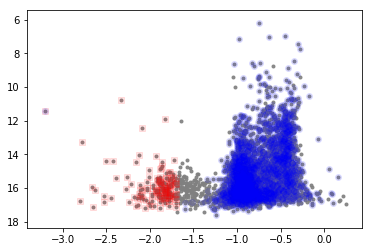

In [18]:
# all
plt.scatter(gaia_2mass_wise['w1mpro'] - gaia_2mass_wise['j_m'], gaia_2mass_wise['j_m'], 
            marker='.', color='gray', alpha=0.9)

# galaxy tracer
g_tracer = gaia_2mass_wise[gaia_2mass_wise['galaxy_tracer']]
plt.scatter(g_tracer['w1mpro'] - g_tracer['j_m'], g_tracer['j_m'], 
            marker='s', color='red', alpha=0.1)

# star tracer
s_tracer = gaia_2mass_wise[gaia_2mass_wise['star_tracer']]
plt.scatter(s_tracer['w1mpro'] - s_tracer['j_m'], s_tracer['j_m'], 
            marker='o', color='blue', alpha=0.1)

plt.gca().invert_yaxis()

In [19]:
# list of parameters
params = ['j_m', 'h_m', 'ks_m', 
          'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro', 
          'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']

### Check Masked Value, replace with mean value of parameters

In [20]:
## check Masked value
# unmasked value = 0 
# NaN, INF

ma_p = np.zeros(len(params))
print("Number of masked value (NULL): ")
print(gaia_2mass_wise['w4mpro'][gaia_2mass_wise['w4mpro'] == ma.masked].data)
for i,p in enumerate(params):
    mean_p = np.mean(gaia_2mass_wise[p])
    
    idx_masked = np.where(gaia_2mass_wise[p] == ma.masked)[0]
    
    gaia_2mass_wise.add_column((gaia_2mass_wise[p] == ma.masked).data, name=p+'_mask')
    
    ma_p[i] = len(idx_masked)
    for idx in idx_masked:
        gaia_2mass_wise[p] = mean_p

    print(p, '  ', ma_p[i], '  ', ma_p[i]/num_gaia_2mass_wise*100, '%')

Number of masked value (NULL): 
[]
j_m    0.0    0.0 %
h_m    0.0    0.0 %
ks_m    0.0    0.0 %
w1mpro    0.0    0.0 %
w2mpro    0.0    0.0 %
w3mpro    0.0    0.0 %
w4mpro    0.0    0.0 %
phot_g_mean_mag    0.0    0.0 %
phot_bp_mean_mag    97.0    2.9146634615384617 %
phot_rp_mean_mag    97.0    2.9146634615384617 %


## Select variables

In [21]:
# only color
variables = np.array([gaia_2mass_wise['j_m'] - gaia_2mass_wise['h_m'], 
                      gaia_2mass_wise['j_m'] - gaia_2mass_wise['ks_m'], 
                      gaia_2mass_wise['h_m'] - gaia_2mass_wise['ks_m'],
                      gaia_2mass_wise['w1mpro'] - gaia_2mass_wise['w2mpro'],
                      gaia_2mass_wise['w1mpro'] - gaia_2mass_wise['w3mpro'],
                      gaia_2mass_wise['w1mpro'] - gaia_2mass_wise['w4mpro'],
                      gaia_2mass_wise['w2mpro'] - gaia_2mass_wise['w3mpro'],
                      gaia_2mass_wise['w2mpro'] - gaia_2mass_wise['w4mpro'],
                      gaia_2mass_wise['w3mpro'] - gaia_2mass_wise['w4mpro'],
                      gaia_2mass_wise['phot_g_mean_mag'] - gaia_2mass_wise['phot_bp_mean_mag'],
                      gaia_2mass_wise['phot_g_mean_mag'] - gaia_2mass_wise['phot_rp_mean_mag'],
                      gaia_2mass_wise['phot_bp_mean_mag'] - gaia_2mass_wise['phot_rp_mean_mag'],
                      gaia_2mass_wise['j_m'] - gaia_2mass_wise['w1mpro'], 
                      gaia_2mass_wise['j_m'] - gaia_2mass_wise['w2mpro'], 
                      gaia_2mass_wise['j_m'] - gaia_2mass_wise['w3mpro'], 
                      gaia_2mass_wise['j_m'] - gaia_2mass_wise['w4mpro'], 
                      gaia_2mass_wise['h_m'] - gaia_2mass_wise['w1mpro'], 
                      gaia_2mass_wise['h_m'] - gaia_2mass_wise['w2mpro'], 
                      gaia_2mass_wise['h_m'] - gaia_2mass_wise['w3mpro'], 
                      gaia_2mass_wise['h_m'] - gaia_2mass_wise['w4mpro'],
                      gaia_2mass_wise['ks_m'] - gaia_2mass_wise['w1mpro'], 
                      gaia_2mass_wise['ks_m'] - gaia_2mass_wise['w2mpro'], 
                      gaia_2mass_wise['ks_m'] - gaia_2mass_wise['w3mpro'], 
                      gaia_2mass_wise['ks_m'] - gaia_2mass_wise['w4mpro'],
                      gaia_2mass_wise['j_m'] - gaia_2mass_wise['phot_g_mean_mag'], 
                      gaia_2mass_wise['j_m'] - gaia_2mass_wise['phot_bp_mean_mag'], 
                      gaia_2mass_wise['j_m'] - gaia_2mass_wise['phot_rp_mean_mag'], 
                      gaia_2mass_wise['h_m'] - gaia_2mass_wise['phot_g_mean_mag'], 
                      gaia_2mass_wise['h_m'] - gaia_2mass_wise['phot_bp_mean_mag'], 
                      gaia_2mass_wise['h_m'] - gaia_2mass_wise['phot_rp_mean_mag'],
                      gaia_2mass_wise['ks_m'] - gaia_2mass_wise['phot_g_mean_mag'], 
                      gaia_2mass_wise['ks_m'] - gaia_2mass_wise['phot_bp_mean_mag'], 
                      gaia_2mass_wise['ks_m'] - gaia_2mass_wise['phot_rp_mean_mag'],
                      gaia_2mass_wise['w1mpro'] - gaia_2mass_wise['phot_g_mean_mag'],
                      gaia_2mass_wise['w1mpro'] - gaia_2mass_wise['phot_bp_mean_mag'],
                      gaia_2mass_wise['w1mpro'] - gaia_2mass_wise['phot_rp_mean_mag'],
                      gaia_2mass_wise['w2mpro'] - gaia_2mass_wise['phot_g_mean_mag'],
                      gaia_2mass_wise['w2mpro'] - gaia_2mass_wise['phot_bp_mean_mag'],
                      gaia_2mass_wise['w2mpro'] - gaia_2mass_wise['phot_rp_mean_mag'],
                      gaia_2mass_wise['w3mpro'] - gaia_2mass_wise['phot_g_mean_mag'],
                      gaia_2mass_wise['w3mpro'] - gaia_2mass_wise['phot_bp_mean_mag'],
                      gaia_2mass_wise['w3mpro'] - gaia_2mass_wise['phot_rp_mean_mag'],
                      gaia_2mass_wise['w4mpro'] - gaia_2mass_wise['phot_g_mean_mag'],
                      gaia_2mass_wise['w4mpro'] - gaia_2mass_wise['phot_bp_mean_mag'],
                      gaia_2mass_wise['w4mpro'] - gaia_2mass_wise['phot_rp_mean_mag']
                     ])

# variables = np.array([gaia_2mass_wise['j_m'] - gaia_2mass_wise['w1mpro'], 
#                       gaia_2mass_wise['j_m'] - gaia_2mass_wise['w2mpro'], 
#                       gaia_2mass_wise['j_m'] - gaia_2mass_wise['w3mpro'], 
#                       gaia_2mass_wise['j_m'] - gaia_2mass_wise['w4mpro'], 
#                       gaia_2mass_wise['h_m'] - gaia_2mass_wise['w1mpro'], 
#                       gaia_2mass_wise['h_m'] - gaia_2mass_wise['w2mpro'], 
#                       gaia_2mass_wise['h_m'] - gaia_2mass_wise['w3mpro'], 
#                       gaia_2mass_wise['h_m'] - gaia_2mass_wise['w4mpro'],
#                       gaia_2mass_wise['ks_m'] - gaia_2mass_wise['w1mpro'], 
#                       gaia_2mass_wise['ks_m'] - gaia_2mass_wise['w2mpro'], 
#                       gaia_2mass_wise['ks_m'] - gaia_2mass_wise['w3mpro'], 
#                       gaia_2mass_wise['ks_m'] - gaia_2mass_wise['w4mpro'],
#                       gaia_2mass_wise['j_m'] - gaia_2mass_wise['phot_g_mean_mag'], 
#                       gaia_2mass_wise['j_m'] - gaia_2mass_wise['phot_bp_mean_mag'], 
#                       gaia_2mass_wise['j_m'] - gaia_2mass_wise['phot_rp_mean_mag'], 
#                       gaia_2mass_wise['h_m'] - gaia_2mass_wise['phot_g_mean_mag'], 
#                       gaia_2mass_wise['h_m'] - gaia_2mass_wise['phot_bp_mean_mag'], 
#                       gaia_2mass_wise['h_m'] - gaia_2mass_wise['phot_rp_mean_mag'],
#                       gaia_2mass_wise['ks_m'] - gaia_2mass_wise['phot_g_mean_mag'], 
#                       gaia_2mass_wise['ks_m'] - gaia_2mass_wise['phot_bp_mean_mag'], 
#                       gaia_2mass_wise['ks_m'] - gaia_2mass_wise['phot_rp_mean_mag'],
#                       gaia_2mass_wise['w1mpro'] - gaia_2mass_wise['phot_g_mean_mag'],
#                       gaia_2mass_wise['w1mpro'] - gaia_2mass_wise['phot_bp_mean_mag'],
#                       gaia_2mass_wise['w1mpro'] - gaia_2mass_wise['phot_rp_mean_mag'],
#                       gaia_2mass_wise['w2mpro'] - gaia_2mass_wise['phot_g_mean_mag'],
#                       gaia_2mass_wise['w2mpro'] - gaia_2mass_wise['phot_bp_mean_mag'],
#                       gaia_2mass_wise['w2mpro'] - gaia_2mass_wise['phot_rp_mean_mag'],
#                       gaia_2mass_wise['w3mpro'] - gaia_2mass_wise['phot_g_mean_mag'],
#                       gaia_2mass_wise['w3mpro'] - gaia_2mass_wise['phot_bp_mean_mag'],
#                       gaia_2mass_wise['w3mpro'] - gaia_2mass_wise['phot_rp_mean_mag'],
#                       gaia_2mass_wise['w4mpro'] - gaia_2mass_wise['phot_g_mean_mag'],
#                       gaia_2mass_wise['w4mpro'] - gaia_2mass_wise['phot_bp_mean_mag'],
#                       gaia_2mass_wise['w4mpro'] - gaia_2mass_wise['phot_rp_mean_mag']
#                      ])


# variables = np.array([gaia_2mass_wise['j_m'] - gaia_2mass_wise['w1mpro'], 
#                       gaia_2mass_wise['j_m'] - gaia_2mass_wise['w2mpro'], 
#                       gaia_2mass_wise['j_m'] - gaia_2mass_wise['w3mpro'],
#                       gaia_2mass_wise['h_m'] - gaia_2mass_wise['w1mpro'], 
#                       gaia_2mass_wise['h_m'] - gaia_2mass_wise['w2mpro'], 
#                       gaia_2mass_wise['h_m'] - gaia_2mass_wise['w3mpro'],
#                       gaia_2mass_wise['ks_m'] - gaia_2mass_wise['w1mpro'], 
#                       gaia_2mass_wise['ks_m'] - gaia_2mass_wise['w2mpro'], 
#                       gaia_2mass_wise['ks_m'] - gaia_2mass_wise['w3mpro'],
#                       gaia_2mass_wise['j_m'] - gaia_2mass_wise['phot_g_mean_mag']
#                      ])

# variables = np.array([gaia_2mass_wise['j_m'] - gaia_2mass_wise['w1mpro'], 
#                       gaia_2mass_wise['j_m'] - gaia_2mass_wise['phot_g_mean_mag'],
#                       gaia_2mass_wise['w1mpro'] - gaia_2mass_wise['phot_g_mean_mag']
#                      ])


variables = variables.T

# Analysis


## PCA

In [22]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')


# X = imp.transform(variables)
X = scale(variables)

n_pcacomp = 4
pca = PCA(n_components=n_pcacomp)
X_pca = pca.fit(X).transform(X)

print(pca.components_)
print(pca.explained_variance_)

[[-6.81656945e-02 -9.00547836e-02 -5.50578475e-02 -4.97286577e-02
  -1.81140546e-01 -1.89223851e-01 -1.74739397e-01 -1.83988122e-01
  -1.13138846e-01 -1.95872362e-01 -1.95872362e-01 -5.79874039e-50
  -7.87936109e-02 -7.99981754e-02 -1.90222528e-01 -1.99492952e-01
  -5.21155408e-02 -5.97762287e-02 -1.87586026e-01 -1.97047055e-01
  -9.02835966e-03 -3.07161614e-02 -1.83605508e-01 -1.93056892e-01
   1.03928642e-01 -2.00120128e-01 -2.00120128e-01  1.06546620e-01
  -1.97403403e-01 -1.97403403e-01  1.08239688e-01 -1.92959047e-01
  -1.92959047e-01  1.00681744e-01 -1.87857433e-01 -1.87857433e-01
   9.99324833e-02 -1.82254224e-01 -1.82254224e-01  1.80423889e-01
  -1.09019525e-01 -1.09019525e-01  1.93856218e-01 -2.11265760e-02
  -2.11265760e-02]
 [ 1.19201570e-01  1.75800547e-01  1.18993941e-01  1.77049570e-01
  -7.00034426e-02 -9.85748409e-02 -9.64839331e-02 -1.19602696e-01
  -1.07408576e-01  6.62065568e-02  6.62065568e-02  2.39439190e-48
   2.68251521e-01  2.75022688e-01  1.93506948e-02 -2.4736

In [23]:
# change X_pca to Table
pca_names = ['PC'+str(i) for i in range(n_pcacomp)]
table_pca = Table(X_pca, names=pca_names)

# add X_pca table to DATA table
gaia_2mass_wise.add_columns(table_pca.columns.values())

In [24]:
# PC_plot 
def plot_pc(pc_x='PC0', pc_y='PC1'):
    plt.scatter(gaia_2mass_wise[pc_x], gaia_2mass_wise[pc_y], marker='.', color='gray', alpha=0.9)

    ## Overplot from tracer
    g_tracer = gaia_2mass_wise[gaia_2mass_wise['galaxy_tracer']]
    plt.scatter(g_tracer[pc_x], g_tracer[pc_y], marker='s', color='red', alpha=0.1)

    s_tracer = gaia_2mass_wise[gaia_2mass_wise['star_tracer']]
    plt.scatter(s_tracer[pc_x], s_tracer[pc_y], marker='s', color='blue', alpha=0.1)
    
    plt.xlabel(pc_x)
    plt.ylabel(pc_y)
    

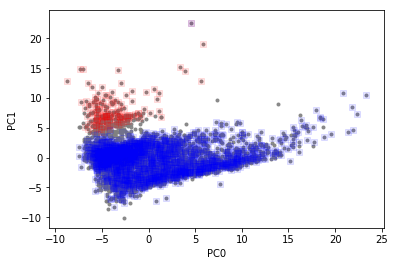

In [25]:
plot_pc('PC0', 'PC1')

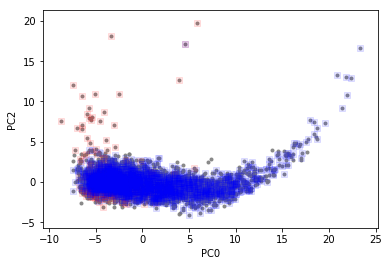

In [26]:
plot_pc('PC0', 'PC2')

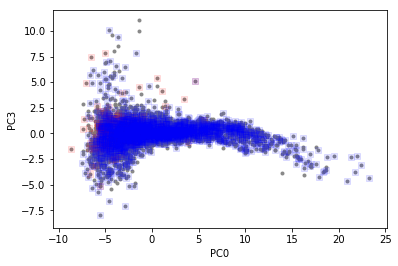

In [27]:
plot_pc('PC0', 'PC3')

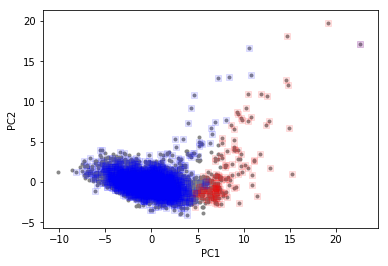

In [28]:
plot_pc('PC1', 'PC2')

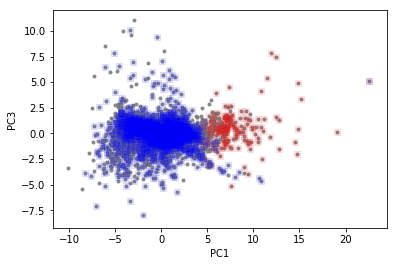

In [29]:
plot_pc('PC1', 'PC3')

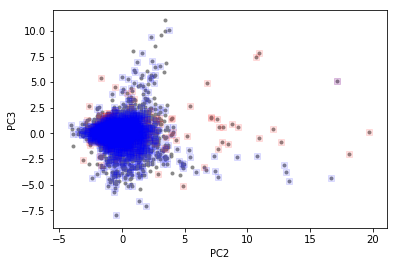

In [30]:
plot_pc('PC2', 'PC3')

## t-SNE

In [31]:
from sklearn.manifold import TSNE
X = scale(variables)
n_tsnecomp = 2
X_tsne = TSNE(n_components=n_tsnecomp).fit_transform(X)

In [32]:
# change X_tsne to table
tsne_names = ['tSNE'+str(i) for i in range(n_tsnecomp)]
table_tsne = Table(X_tsne, names=tsne_names)

# add X_pca table to DATA table
gaia_2mass_wise.add_columns(table_tsne.columns.values())

In [55]:
 def plot_tsne(pc_x='tSNE0', pc_y='tSNE1'):
    plt.scatter(gaia_2mass_wise[pc_x], gaia_2mass_wise[pc_y], marker='.', color='gray', alpha=0.9)

    ## Overplot from tracer
    g_tracer = gaia_2mass_wise[gaia_2mass_wise['galaxy_tracer']]
    plt.scatter(g_tracer[pc_x], g_tracer[pc_y], marker='.', color='red', alpha=0.1)

    s_tracer = gaia_2mass_wise[gaia_2mass_wise['star_tracer']]
    plt.scatter(s_tracer[pc_x], s_tracer[pc_y], marker='.', color='blue', alpha=0.1)
    
    m_tracer = gaia_2mass_wise[gaia_2mass_wise['phot_bp_mean_mag_mask']]
    plt.scatter(m_tracer[pc_x], m_tracer[pc_y], marker='.', color='green', alpha=0.1)
    
    plt.xlabel(pc_x)
    plt.ylabel(pc_y)

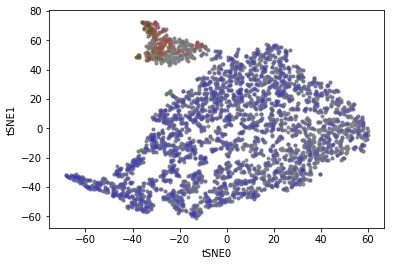

In [56]:
plot_tsne()

### DBSCAN for tSNE result

In [35]:
from sklearn.cluster import DBSCAN
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import sigmaclip

In [36]:
X_dbscan = np.array([gaia_2mass_wise['tSNE0'], gaia_2mass_wise['tSNE1']]).T

#### Voronoi to find best eps

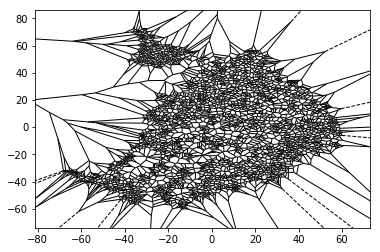

In [37]:
vor = Voronoi(X_dbscan)

voronoi_plot_2d(vor, show_points=False, point_size=1, show_vertices=False)
plt.show()

Median:  0.9626957836042064
Mean:  1.1243919194955636


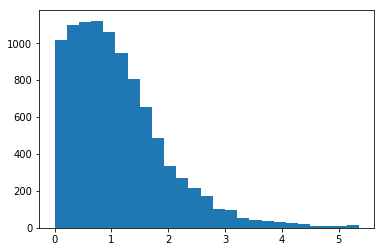

In [38]:
array_length = []

for vpair in vor.ridge_vertices:
    if vpair[0] >= 0 and vpair[1] >= 0:
        v0 = vor.vertices[vpair[0]]
        v1 = vor.vertices[vpair[1]]
        
        length = np.sqrt((v0[0]-v1[0])**2 + (v0[1]-v1[1])**2)
        array_length.append(length)

# plt.hist(array_length, bins=25);
# Sigma clip: 5 sigma, before calculating median
arr, low, upp = sigmaclip(array_length, 5, 5)

plt.hist(arr, bins=25);
        
print("Median: ", np.median(arr))
print("Mean: ", np.mean(arr))

In [39]:
hist, bin_edges = np.histogram(arr, density=True)

In [40]:
# just to easily estimate
# often need to be adjusted manually
epsilon = 3 * np.median(arr) 
minsamp = 6
print("DBSCAN Epsilon: ", epsilon)
print("DBSCAN minPts: ", minsamp)

db = DBSCAN(eps=epsilon, min_samples=minsamp).fit(X_dbscan)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# print(labels)

DBSCAN Epsilon:  2.888087350812619
DBSCAN minPts:  6
Estimated number of clusters: 5
Estimated number of noise points: 21


In [41]:
# add X_pca table to DATA table
gaia_2mass_wise.add_column(Column(labels), name="dbscan_label")

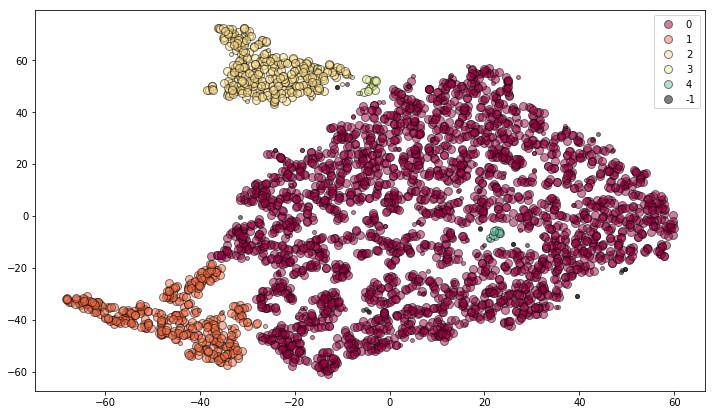

In [42]:
####
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(12, 7))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_dbscan[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', 
             markerfacecolor=tuple(col), markeredgecolor='black', 
             markersize=8, alpha=0.5, label=k)

    xy = X_dbscan[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', 
             markerfacecolor=tuple(col), markeredgecolor='black', 
             markersize=4, alpha=0.5)
    
plt.legend(loc="best")

### Plot t-SNE result based on other parameters

In [122]:
def plot_tsne_par(pc_x='tSNE0', pc_y='tSNE1', par=gaia_2mass_wise['w1mpro'] - gaia_2mass_wise['j_m']):
    co = (((par - np.min(par))) / (np.max(par) - np.min(par)))
    plt.scatter(gaia_2mass_wise[pc_x], gaia_2mass_wise[pc_y], 
                marker='o', s=10,
                c=co, cmap=plt.cm.get_cmap('plasma'), alpha=0.5)
    
    plt.xlim([np.min(gaia_2mass_wise[pc_x])-10, np.max(gaia_2mass_wise[pc_x])+10])
    plt.ylim([np.min(gaia_2mass_wise[pc_y])-10, np.max(gaia_2mass_wise[pc_y])+10])

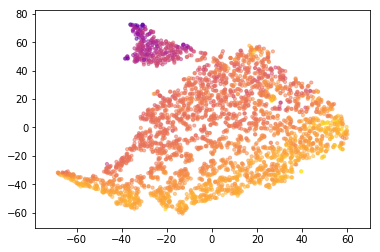

In [151]:
plot_tsne_par(par=gaia_2mass_wise['w1mpro'] - gaia_2mass_wise['j_m'])

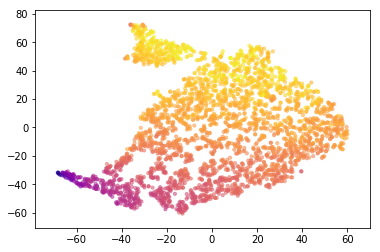

In [124]:
plot_tsne_par(par=gaia_2mass_wise['phot_g_mean_mag'])

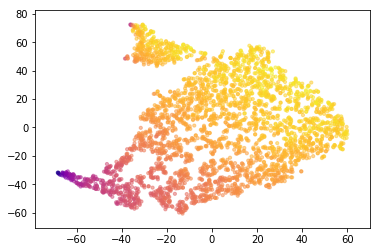

In [136]:
plot_tsne_par(par=gaia_2mass_wise['j_m'])

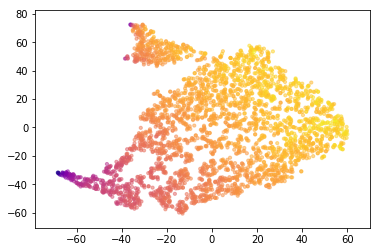

In [137]:
plot_tsne_par(par=gaia_2mass_wise['w1mpro'])

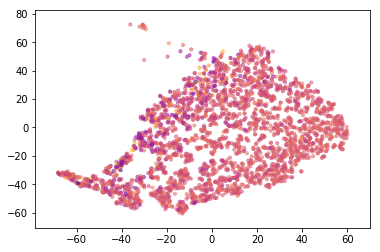

In [125]:
plot_tsne_par(par=gaia_2mass_wise['pmra'])

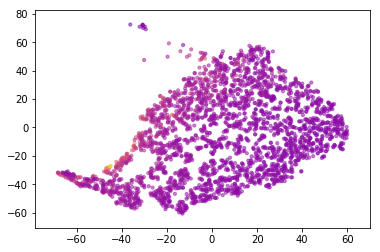

In [126]:
plot_tsne_par(par=gaia_2mass_wise['parallax'])

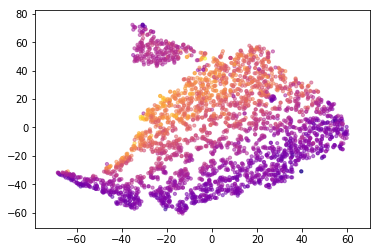

In [127]:
plot_tsne_par(par=gaia_2mass_wise['bp_rp'])

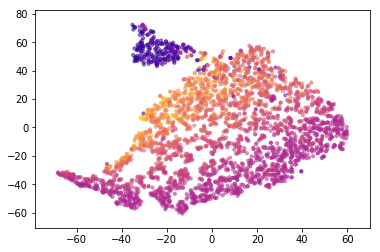

In [128]:
plot_tsne_par(par=gaia_2mass_wise['bp_g'])

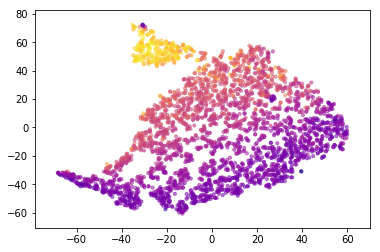

In [129]:
plot_tsne_par(par=gaia_2mass_wise['g_rp'])

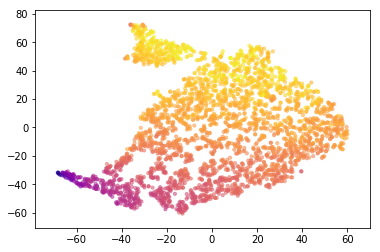

In [148]:
plot_tsne_par(par=(gaia_2mass_wise['phot_g_mean_mag'] - gaia_2mass_wise['phot_rp_mean_mag']))

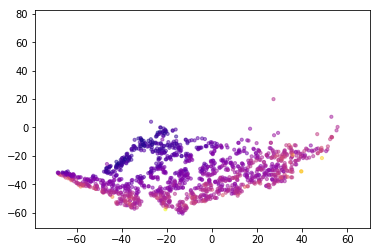

In [130]:
plot_tsne_par(par=gaia_2mass_wise['teff_val'])

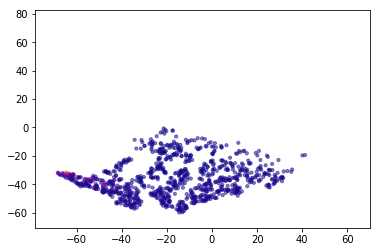

In [131]:
plot_tsne_par(par=gaia_2mass_wise['radius_val'])

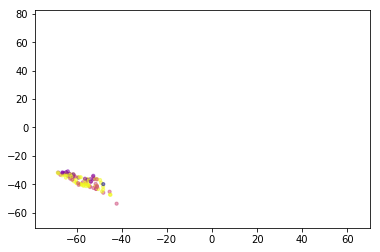

In [132]:
plot_tsne_par(par=gaia_2mass_wise['rv_template_logg'])

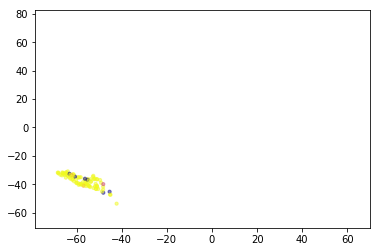

In [133]:
plot_tsne_par(par=gaia_2mass_wise['rv_template_fe_h'])

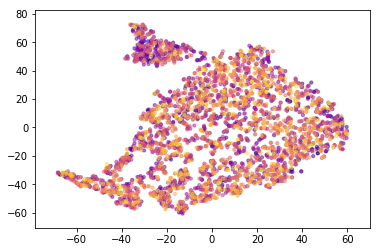

In [144]:
plot_tsne_par(par=gaia_2mass_wise['dec'])

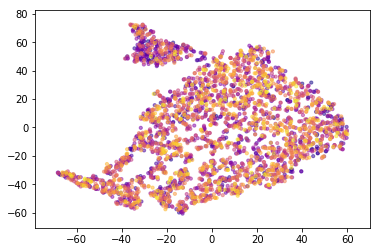

In [134]:
plot_tsne_par(par=gaia_2mass_wise['b'])

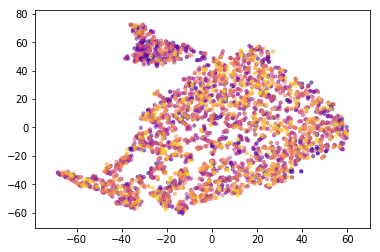

In [143]:
plot_tsne_par(par=gaia_2mass_wise['ecl_lat'])

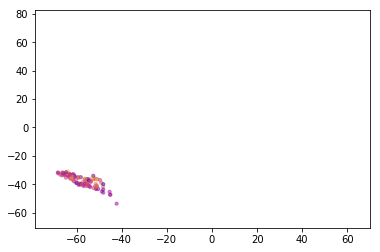

In [135]:
plot_tsne_par(par=gaia_2mass_wise['radial_velocity'])

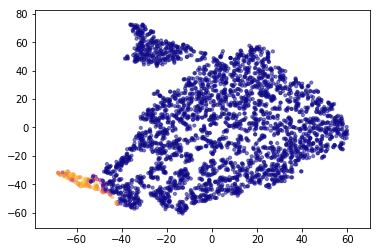

In [138]:
plot_tsne_par(par=gaia_2mass_wise['astrometric_n_obs_ac'])

In [152]:
## Select only galaxy based on t-SNE

In [161]:
galaxy_tsne = gaia_2mass_wise[gaia_2mass_wise['dbscan_label']==2]

In [162]:
def plot_galaxy_tsne_par(pc_x='tSNE0', pc_y='tSNE1', par=galaxy_tsne['w1mpro'] - galaxy_tsne['j_m']):
    co = (((par - np.min(par))) / (np.max(par) - np.min(par)))
    plt.scatter(galaxy_tsne[pc_x], galaxy_tsne[pc_y], 
                marker='o', s=10,
                c=co, cmap=plt.cm.get_cmap('plasma'), alpha=0.5)
    
    plt.xlim([np.min(galaxy_tsne[pc_x])-10, np.max(galaxy_tsne[pc_x])+10])
    plt.ylim([np.min(galaxy_tsne[pc_y])-10, np.max(galaxy_tsne[pc_y])+10])

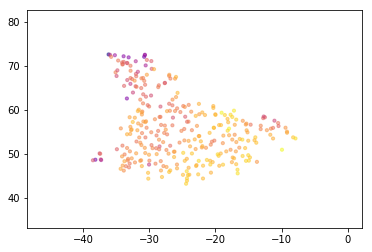

In [163]:
plot_galaxy_tsne_par(par=galaxy_tsne['w1mpro'] - galaxy_tsne['j_m'])

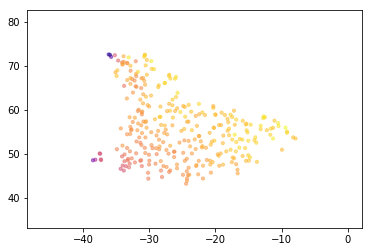

In [164]:
plot_galaxy_tsne_par(par=galaxy_tsne['j_m'])

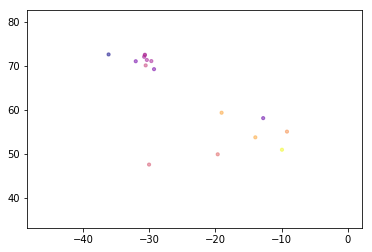

In [165]:
plot_galaxy_tsne_par(par=galaxy_tsne['parallax'])

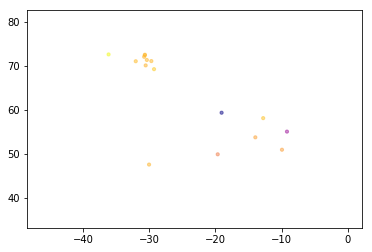

In [167]:
plot_galaxy_tsne_par(par=galaxy_tsne['pmdec'])

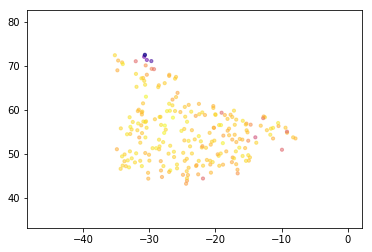

In [168]:
plot_galaxy_tsne_par(par=galaxy_tsne['g_rp'])

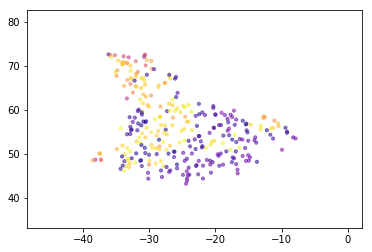

In [174]:
plot_galaxy_tsne_par(par=(galaxy_tsne['w1mpro'] - galaxy_tsne['j_m'])%-1.7)

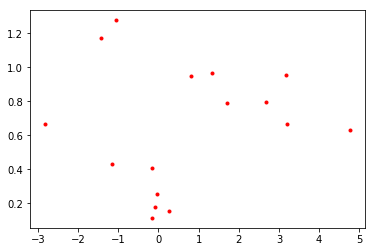

In [180]:
plt.plot(galaxy_tsne['parallax'], galaxy_tsne['parallax_error'], 'r.');
# majority are NULLs

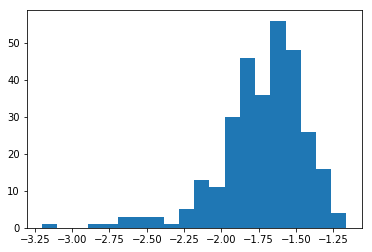

In [182]:
plt.hist(galaxy_tsne['w1mpro'] - galaxy_tsne['j_m'], bins=20);

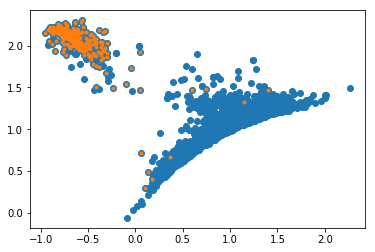

In [190]:
plt.plot(gaia_2mass_wise['bp_g'], gaia_2mass_wise['g_rp'], 'o')
plt.plot(galaxy_tsne['bp_g'], galaxy_tsne['g_rp'], '.');

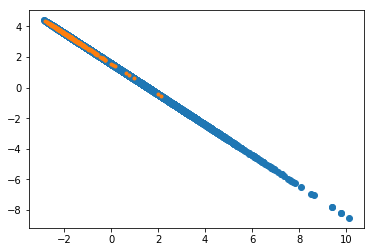

In [199]:
# check consistency
plt.plot(gaia_2mass_wise['phot_bp_mean_mag']-gaia_2mass_wise['phot_g_mean_mag'], 
         gaia_2mass_wise['phot_g_mean_mag']-gaia_2mass_wise['phot_rp_mean_mag'], 'o')
plt.plot(galaxy_tsne['phot_bp_mean_mag']-galaxy_tsne['phot_g_mean_mag'], 
         galaxy_tsne['phot_g_mean_mag']-galaxy_tsne['phot_rp_mean_mag'], '.')

In [ ]:
# why difference?

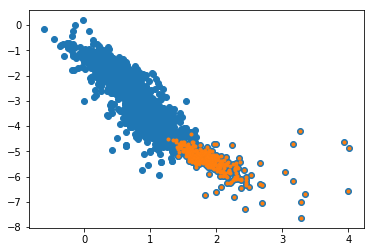

In [196]:
plt.plot(gaia_2mass_wise['j_m'] - gaia_2mass_wise['w2mpro'], 
         gaia_2mass_wise['w2mpro'] - gaia_2mass_wise['phot_g_mean_mag'], 'o')
plt.plot(galaxy_tsne['j_m'] - galaxy_tsne['w2mpro'], 
         galaxy_tsne['w2mpro'] - galaxy_tsne['phot_g_mean_mag'], '.')

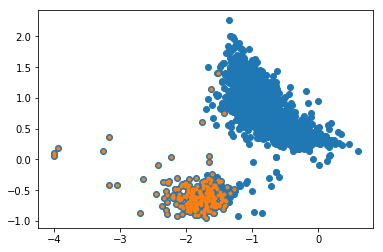

In [202]:
plt.plot(gaia_2mass_wise['w2mpro']- gaia_2mass_wise['j_m'], 
         gaia_2mass_wise['bp_g'], 'o')
plt.plot(galaxy_tsne['w2mpro'] - galaxy_tsne['j_m'], 
         galaxy_tsne['bp_g'], '.')

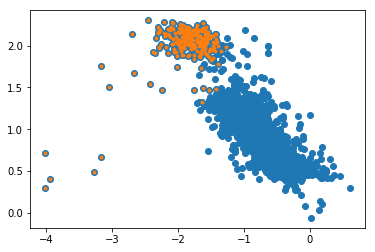

In [203]:
plt.plot(gaia_2mass_wise['w2mpro']- gaia_2mass_wise['j_m'], 
         gaia_2mass_wise['g_rp'], 'o')
plt.plot(galaxy_tsne['w2mpro'] - galaxy_tsne['j_m'], 
         galaxy_tsne['g_rp'], '.')

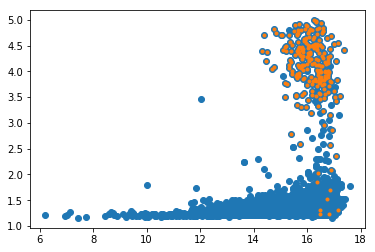

In [208]:
plt.plot(gaia_2mass_wise["j_m"], gaia_2mass_wise["phot_bp_rp_excess_factor"], 'o');
plt.plot(galaxy_tsne["j_m"], galaxy_tsne["phot_bp_rp_excess_factor"], '.');